# Non-Maximum Supression


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark(cores=4)
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/23 21:57:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/23 21:57:35 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Wed Apr 23 09:57:37 PM EDT 2025


### test dataset

In [4]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data"
test_path = f"{data_path}/parquet/test_2025"
test_df = spark.read.parquet(test_path)
test_df.printSchema()
test_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)



+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-Pla-B3-201907...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-E5-20180...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B1-20140...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-Pla-D4-201507...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-F3-20190...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# get image
target_image_name = "CBN-can-A1-20230705.jpg"
image_row = test_df.filter(test_df.image_name == target_image_name).collect()

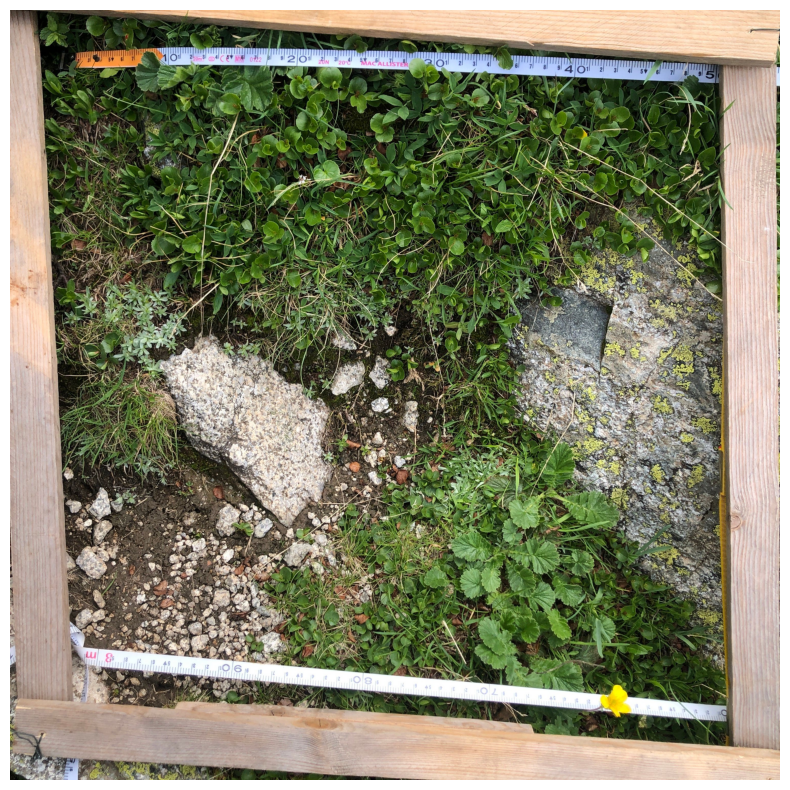

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from plantclef.serde import deserialize_image


# extract image
img_bytes = image_row[0]["data"]
np_arr = np.frombuffer(img_bytes, np.uint8)
img_cv2 = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
img = deserialize_image(img_bytes)  # Pillow image

# show or inspect the image
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
# plot Pillow image
plt.figure(figsize=(10, 10))
plt.imshow(img)  # img_rgb
plt.axis("off")
plt.show()

In [ ]:
import torch
from transformers import (
    SamModel,
    SamProcessor,
    AutoProcessor,
    AutoModelForZeroShotObjectDetection,
)


checkpoint_path_sam = "facebook/sam-vit-huge"
checkpoint_path_groundingdino = "IDEA-Research/grounding-dino-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# https://huggingface.co/docs/transformers/main/en/model_doc/sam
sam_model = SamModel.from_pretrained(checkpoint_path_sam).to(device)
sam_processor = SamProcessor.from_pretrained(checkpoint_path_sam)
# https://huggingface.co/docs/transformers/main/en/model_doc/grounding-dino
groundingdino_model = AutoModelForZeroShotObjectDetection.from_pretrained(
    checkpoint_path_groundingdino
).to(device)
groundingdino_processor = AutoProcessor.from_pretrained(checkpoint_path_groundingdino)

Using device: cuda


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [76]:
# GroundingDINO params
IMAGE_NAME = "CBN-can-A1-20230705.jpg"
ALL_CLASSES = [
    "leaf",
    "flower",
    "plant",
    "sand",
    "wood",
    "stone",
    "tape",
    "tree",
    "rock",
    "vegetation",
]
CLASSES = ["single leaf", "single flower", "entire plant", "rocks"]
BOX_THRESHOLD = 0.15
TEXT_THRESHOLD = 0.1


def detect(image) -> dict:
    # predict with groundingdino
    inputs = groundingdino_processor(
        images=image,
        text=CLASSES,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = groundingdino_model(**inputs)

    # dictionary with boxes, scores, text_labels
    return groundingdino_processor.post_process_grounded_object_detection(
        outputs,
        threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        target_sizes=[(image.height, image.width)],
    )[0]  # return the dictionary inside the list


detections = detect(image=img)
detections.keys()

dict_keys(['scores', 'boxes', 'text_labels', 'labels'])

In [77]:
detections["text_labels"]

['single flower',
 'rocks',
 'rocks',
 'entire plant',
 'entire plant rocks',
 'single leaf',
 'single leaf',
 'rocks',
 'single leaf',
 'single leaf',
 'single leaf',
 'rocks',
 'rocks',
 'rocks',
 'entire plant',
 'rocks',
 'rocks',
 'entire plant',
 'single leaf',
 'rocks',
 'single leaf',
 'rocks',
 'entire plant',
 'rocks',
 'entire plant',
 'rocks',
 'rocks',
 'single leaf',
 'rocks',
 'single leaf',
 'rocks',
 'rocks',
 'single leaf',
 'rocks',
 'rocks',
 'single leaf',
 'single leaf',
 'single leaf',
 'single leaf',
 'single leaf',
 'entire plant',
 'single leaf',
 'rocks',
 'entire plant',
 'entire plant',
 'single leaf',
 'single leaf',
 'rocks',
 'single leaf',
 'single leaf',
 'rocks',
 'entire plant',
 'entire plant']

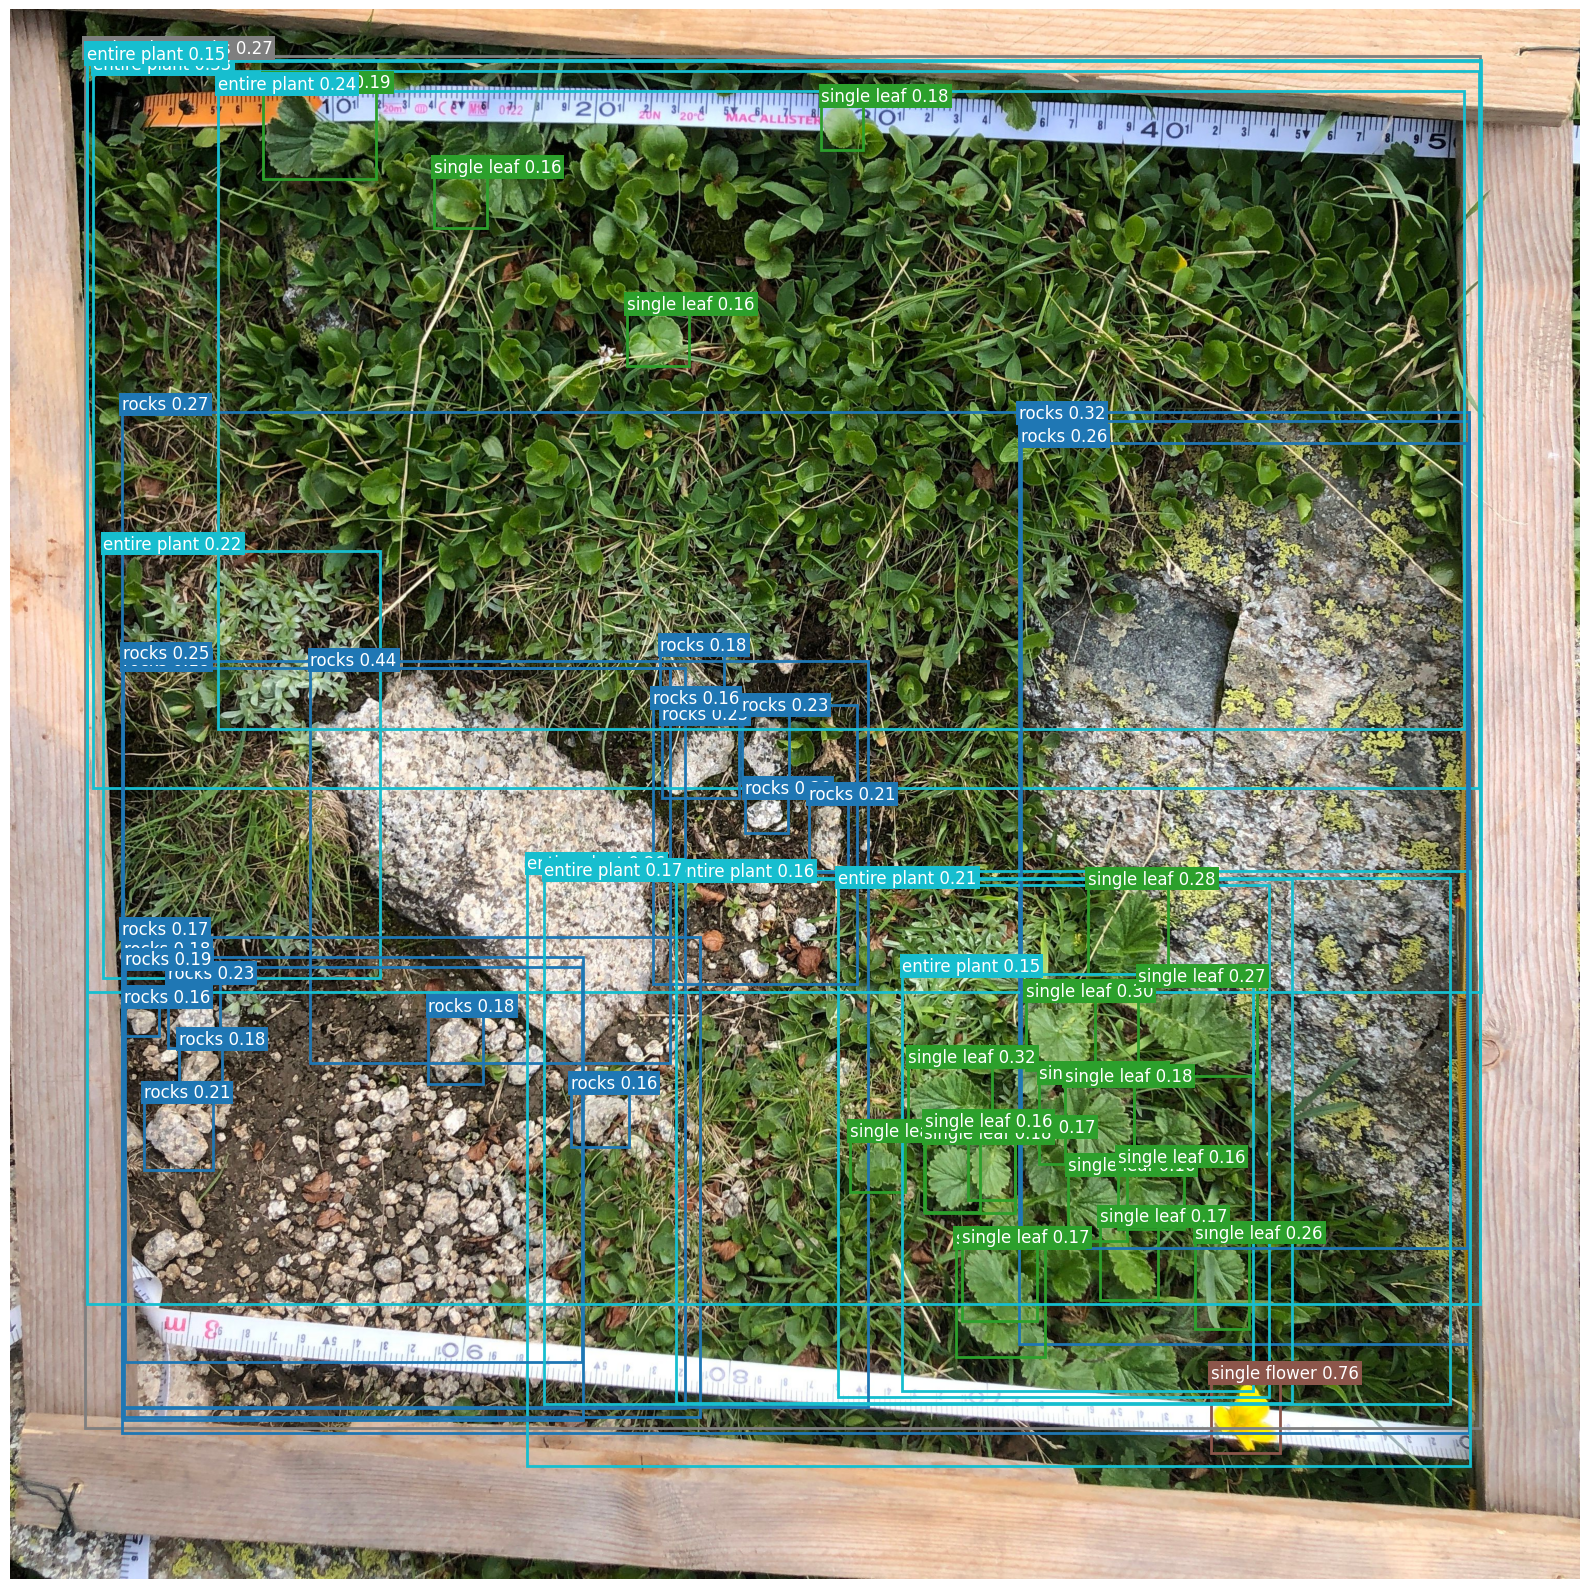

In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# assign colors to labels
unique_labels = list(set(detections["text_labels"]))
cmap = plt.get_cmap("tab10", len(unique_labels))
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

# Create a matplotlib figure
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(img)  # Pillow image

# Loop through detections and draw boxes with corresponding label colors
for box, label, score in zip(
    detections["boxes"], detections["text_labels"], detections["scores"]
):
    x_min, y_min, x_max, y_max = box.tolist()
    color = label_to_color[label]

    # Create a rectangle patch
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=2,
        edgecolor=color,
        facecolor="none",
    )
    ax.add_patch(rect)

    # Add label text
    ax.text(
        x_min,
        y_min - 5,
        f"{label} {score:.2f}",
        fontsize=12,
        color="white",
        bbox=dict(facecolor=color, edgecolor="none", pad=2.0),
    )

plt.axis("off")
plt.tight_layout()
plt.show()